# Bidirectional LSTM

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Process features for LSTM

In [65]:
df_train = pd.read_csv("train_features.csv")
df_test = pd.read_csv("test_features.csv")
df_valid = pd.read_csv("valid_features.csv")

import ast
df_train["text"] = df_train["text"].apply(ast.literal_eval)
df_train["pos_seq"] = df_train["pos_seq"].apply(ast.literal_eval)

df_valid["text"] = df_valid["text"].apply(ast.literal_eval)
df_valid["pos_seq"] = df_valid["pos_seq"].apply(ast.literal_eval)

df_test["text"] = df_test["text"].apply(ast.literal_eval)
df_test["pos_seq"] = df_test["pos_seq"].apply(ast.literal_eval)

from IPython.display import display
display(df_train.head())


,text,label,sentiment,length_words,pos_seq,N,V,A,P,O,U,N.1,V.1,A.1,P.1,O.1,U.1
0,"[state, slow, to, shut, down, weak, teacher, e...",0,-0.4404,9,"[N, N, P, V, A, A, A, N, N]",4,1,2,1,1,0,4,1,2,1,1,0
1,"[drone, place, fresh, kill, on, step, of, whit...",1,-0.5267,9,"[N, N, A, N, P, N, P, A, N]",5,0,2,2,0,0,5,0,2,2,0,0
2,"[report, :, majority, of, instance, of, people...",1,0.0000,20,"[N, U, N, P, N, P, N, V, N, A, P, N, N, A, P, ...",8,3,3,5,0,1,8,3,3,5,0,1
3,"[sole, remain, lung, fill, with, rich, ,, sati...",1,0.7650,9,"[N, N, N, N, P, A, U, A, N]",5,0,2,1,0,1,5,0,2,1,0,1
4,"[the, gop, 's, stockholm, syndrome]",0,0.0000,5,"[P, N, O, A, N]",2,0,1,1,1,0,2,0,1,1,1,0


### Vocabulary

In [66]:
from collections import Counter
import torch

def build_vocab(tokens_list, min_freq=1):
    
    counter = Counter()
    for sentence in tokens_list:
        for tokens in sentence:
            # print(tokens)
        
            # counter.update(tokens)
            counter.update([tokens])

            
    # print(counter)

    vocab = {"<pad>": 0, "<unk>": 1}
    for tok, freq in counter.items():
        # print(tok, freq)
        if freq >= min_freq:
            vocab[tok] = len(vocab)
    return vocab

word_vocab = build_vocab(df_train["text"])
pos_vocab = build_vocab(df_train["pos_seq"])
print(f"Vocab size: {len(word_vocab)}")
print(f"POS vocab size: {len(pos_vocab)}")



Vocab size: 22169
POS vocab size: 8


In [67]:
def encode(tokens, vocab):
    return [vocab.get(tok, vocab["<unk>"]) for tok in tokens]

df_train["word_ids"] = df_train["text"].apply(lambda x: encode(x, word_vocab))
df_train["pos_ids"] = df_train["pos_seq"].apply(lambda x: encode(x, pos_vocab))

df_valid["word_ids"] = df_valid["text"].apply(lambda x: encode(x, word_vocab))
df_valid["pos_ids"] = df_valid["pos_seq"].apply(lambda x: encode(x, pos_vocab))

df_test["word_ids"] = df_test["text"].apply(lambda x: encode(x, word_vocab))
df_test["pos_ids"] = df_test["pos_seq"].apply(lambda x: encode(x, pos_vocab))

df_train.head()

,text,label,sentiment,length_words,pos_seq,N,V,A,P,O,U,N.1,V.1,A.1,P.1,O.1,U.1,word_ids,pos_ids
0,"[state, slow, to, shut, down, weak, teacher, e...",0,-0.4404,9,"[N, N, P, V, A, A, A, N, N]",4,1,2,1,1,0,4,1,2,1,1,0,"[2, 3, 4, 5, 6, 7, 8, 9, 10]","[2, 2, 3, 4, 5, 5, 5, 2, 2]"
1,"[drone, place, fresh, kill, on, step, of, whit...",1,-0.5267,9,"[N, N, A, N, P, N, P, A, N]",5,0,2,2,0,0,5,0,2,2,0,0,"[11, 12, 13, 14, 15, 16, 17, 18, 19]","[2, 2, 5, 2, 3, 2, 3, 5, 2]"
2,"[report, :, majority, of, instance, of, people...",1,0.0000,20,"[N, U, N, P, N, P, N, V, N, A, P, N, N, A, P, ...",8,3,3,5,0,1,8,3,3,5,0,1,"[20, 21, 22, 17, 23, 17, 24, 25, 26, 27, 15, 2...","[2, 6, 2, 3, 2, 3, 2, 4, 2, 5, 3, 2, 2, 5, 3, ..."
3,"[sole, remain, lung, fill, with, rich, ,, sati...",1,0.7650,9,"[N, N, N, N, P, A, U, A, N]",5,0,2,1,0,1,5,0,2,1,0,1,"[36, 37, 38, 39, 40, 41, 42, 43, 44]","[2, 2, 2, 2, 3, 5, 6, 5, 2]"
4,"[the, gop, 's, stockholm, syndrome]",0,0.0000,5,"[P, N, O, A, N]",2,0,1,1,1,0,2,0,1,1,1,0,"[45, 46, 47, 48, 49]","[3, 2, 7, 5, 2]"


In [68]:
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils

class TextPosDataset(Dataset):
    def __init__(self, df):
        self.word_ids = df["word_ids"].tolist()
        self.pos_ids = df["pos_ids"].tolist()
        self.sentiment = df["sentiment"].tolist()  # float
        self.label = df["label"].tolist()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.word_ids[idx]),
            torch.tensor(self.pos_ids[idx]),
            torch.tensor(self.sentiment[idx], dtype=torch.float),
            torch.tensor(self.label[idx])
        )

def collate(batch):
    words, pos, sent, labels = zip(*batch)
    words = rnn_utils.pad_sequence(words, batch_first=True)
    pos = rnn_utils.pad_sequence(pos, batch_first=True)
    sent = torch.stack(sent)
    labels = torch.stack(labels)
    return words, pos, sent, labels


In [69]:
train_dataset = TextPosDataset(df_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)

valid_dataset = TextPosDataset(df_valid)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, collate_fn=collate)

test_dataset = TextPosDataset(df_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate)



## Model

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WordPosSentNet(nn.Module):
    def __init__(self, vocab_size, pos_vocab_size,
                 word_emb_dim=128, pos_emb_dim=32, hidden_size=32, output_size=2):
        super().__init__()

        # Embeddings
        self.word_emb = nn.Embedding(vocab_size, word_emb_dim, padding_idx=0)
        self.pos_emb = nn.Embedding(pos_vocab_size, pos_emb_dim, padding_idx=0)

        # Bidirectional LSTMs
        self.word_lstm = nn.LSTM(word_emb_dim, hidden_size, batch_first=True, bidirectional=True)
        self.pos_lstm = nn.LSTM(pos_emb_dim, hidden_size//2, batch_first=True, bidirectional=True)

        # Fully connected layers
        fc_input_dim = hidden_size*2 + (hidden_size//2)*2 + 1  # +1 for sentiment
        self.fc = nn.Sequential(
            nn.Linear(fc_input_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, output_size),
            # nn.Linear(output_size, output_size)
        )

    def forward(self, word_ids, pos_ids, sentiment):
        # Embeddings
        word_emb = self.word_emb(word_ids)  # [batch, seq_len, word_emb_dim]
        pos_emb = self.pos_emb(pos_ids)     # [batch, seq_len, pos_emb_dim]

        # LSTM outputs
        word_out, _ = self.word_lstm(word_emb)  # [batch, seq_len, hidden*2]
        pos_out, _ = self.pos_lstm(pos_emb)     # [batch, seq_len, hidden]

        # Take forward last + backward first for bidirectional
        hidden_size = word_out.size(2) // 2
        word_feat = torch.cat((word_out[:, -1, :hidden_size], word_out[:, 0, hidden_size:]), dim=1)

        pos_hidden_size = pos_out.size(2) // 2
        pos_feat = torch.cat((pos_out[:, -1, :pos_hidden_size], pos_out[:, 0, pos_hidden_size:]), dim=1)

        # Concatenate with sentiment (assumed [batch])
        x = torch.cat([word_feat, pos_feat, sentiment.unsqueeze(1)], dim=1)

        # Fully connected layers
        out = self.fc(x)

        return out


## Training

Epoch 1/5 - Train Loss: 0.6681, Train Acc: 0.5927 - Val Loss: 0.6501, Val Acc: 0.6187
Epoch 2/5 - Train Loss: 0.6353, Train Acc: 0.6445 - Val Loss: 0.6239, Val Acc: 0.6522
Epoch 3/5 - Train Loss: 0.6153, Train Acc: 0.6592 - Val Loss: 0.6097, Val Acc: 0.6634
Epoch 4/5 - Train Loss: 0.6031, Train Acc: 0.6679 - Val Loss: 0.5981, Val Acc: 0.6676
Epoch 5/5 - Train Loss: 0.5918, Train Acc: 0.6766 - Val Loss: 0.5918, Val Acc: 0.6690


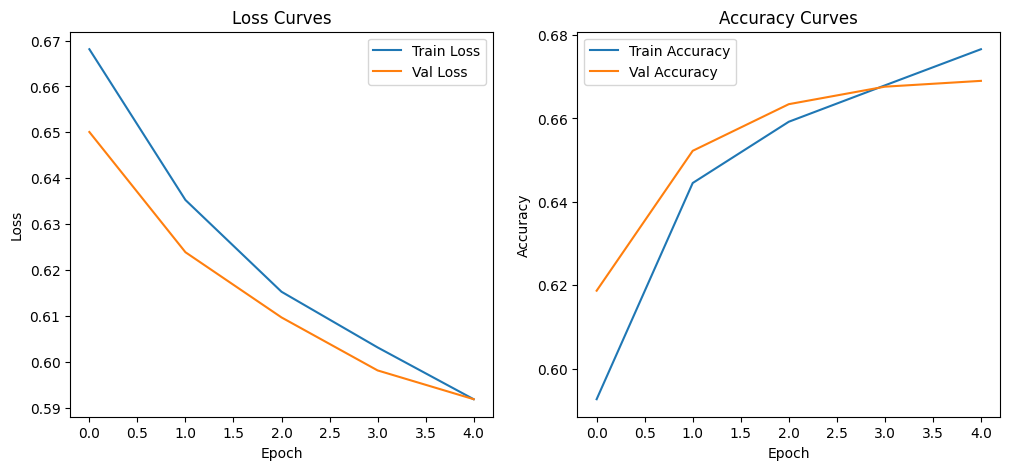

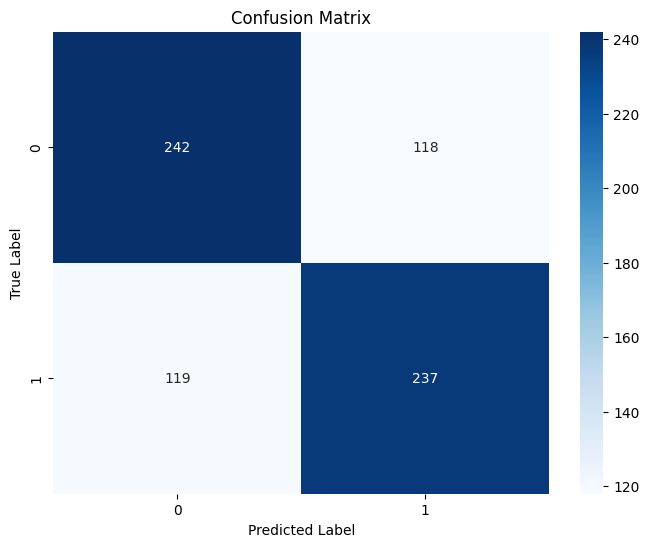

In [140]:
model = WordPosSentNet(len(word_vocab), len(pos_vocab))
optim = torch.optim.SGD(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

num_epochs = 5
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
misclassified = []
for epoch in range(num_epochs):
    # train
    model.train()  
    epoch_loss = 0
    correct = 0
    total = 0

    for words, pos, sent, labels in train_loader:
        words, pos, sent, labels = words.long(), pos.long(), sent.float(), labels.long()
        optim.zero_grad()
        preds = model(words, pos, sent)
        loss = loss_fn(preds, labels)
        loss.backward()
        optim.step()

        epoch_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(preds, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # validation
    
    model.eval() 
    misclassified = [] 
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    all_true = []
    all_pred = []

    with torch.no_grad():
        for words, pos, sent, labels in valid_loader:
            words, pos, sent, labels = words.long(), pos.long(), sent.float(), labels.long()
            preds = model(words, pos, sent)
            loss = loss_fn(preds, labels)

            val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(preds, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            
            wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]

            # Append features, true label, and predicted label for each misclassified sample
            for idx in wrong_idx:
                misclassified.append({
                    'words': words[idx],
                    'pos': pos[idx],
                    'sent': sent[idx],
                    'true_label': labels[idx],
                    'pred_label': predicted[idx]
                })
                
            all_true.extend(labels.tolist())
            all_pred.extend(predicted.tolist())
            
            
            
            

    valid_losses.append(val_loss / val_total)
    valid_accuracies.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f} - "
          f"Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accuracies[-1]:.4f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

cm = confusion_matrix(all_true, all_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [155]:
misclassified.iloc['pred_label']

AttributeError: 'list' object has no attribute 'iloc'

In [145]:
id_to_word = {v: k for k, v in word_vocab.items()}
id_to_pos = {v: k for k, v in pos_vocab.items()}

for i in range(10):
    sample = misclassified[i]
    words_tensor = sample['words']
    pos_tensor = sample['pos']

    words_str = [id_to_word[int(w)] for w in words_tensor if int(w) != 0]
    pos_str = [id_to_pos[int(p)] for p in pos_tensor if int(p) != 0]
    print(f'{words_str}, true label {sample['true_label']} predicted {sample['pred_label']}')
# print("Words:", words_str)
# print("POS tags:", pos_str)
# print("Sentiment:", sample['sent'])
# print("True label:", sample['true_label'])
# print("Predicted:", sample['pred_label'])


['prejudice', 'do', 'not', 'discriminate'], true label 0 predicted 1
['woman', 'get', 'several', 'job', 'offer', 'after', 'hand', 'out', 'resume', 'on', 'the', 'side', 'of', 'the', 'road'], true label 0 predicted 1
['obama', 'host', 'annual', 'ramadan', 'iftar', 'dinner', 'at', 'the', 'white', 'house'], true label 0 predicted 1
['denny', "'s", 'introduces', "'just", 'a', 'humongous', 'bucket', 'of', 'egg', 'and', 'meat', "'"], true label 1 predicted 0
['inside', ':', 'what', 'the', 'star', 'be', 'wear', 'at', 'terrible', 'movie', "'s", 'gala', 'premiere'], true label 1 predicted 0
['get', 'ready', 'to', 'capture', '<unk>', 'in', 'the', 'real', 'world', 'with', 'your', 'smartphone'], true label 0 predicted 1
['grindr', 'now', 'offer', 'reminder', 'for', 'user', 'to', 'get', 'regular', 'hiv', 'test'], true label 0 predicted 1
['scott', 'bakula', 'jump', 'into', 'mccain', "'s", 'body', 'just', 'before', 'election'], true label 1 predicted 0
['chris', 'martin', 'and', 'gwyneth', 'paltrow',

In [146]:
from collections import Counter
import torch

# Dictionaries
id_to_word = {v: k for k, v in word_vocab.items()}
id_to_pos = {v: k for k, v in pos_vocab.items()}

# Analysis containers
all_words = []
all_pos = []
true_labels = []
pred_labels = []
sentiments = []

# Loop through misclassified samples
for sample in misclassified[:50]:  # just look at first 50 to start
    words_tensor = sample['words']
    pos_tensor = sample['pos']
    sent = sample['sent']
    true_label = sample['true_label']
    pred_label = sample['pred_label']

    words_str = [id_to_word[int(w)] for w in words_tensor if int(w) != 0]
    pos_str = [id_to_pos[int(p)] for p in pos_tensor if int(p) != 0]

    # print(f"Words: {words_str}")
    # print(f"POS: {pos_str}")
    # print(f"Sentiment: {sent:.3f}, True label: {true_label}, Predicted: {pred_label}\n")

    all_words.extend(words_str)
    all_pos.extend(pos_str)
    true_labels.append(true_label)
    pred_labels.append(pred_label)
    sentiments.append(sent)

# Simple pattern analysis
print("Most common words in misclassified samples:", Counter(all_words).most_common(10))
print("Most common POS tags in misclassified samples:", Counter(all_pos).most_common(10))

# Average sentiment of misclassified samples
avg_sentiment = torch.tensor(sentiments).float().mean()
print(f"Average sentiment of misclassified samples: {avg_sentiment:.3f}")

# percentage of misclassified samples predicted 0
print(f"Percentage of misclassified samples predicted 0: {pred_labels.count(0) / len(pred_labels) * 100:.2f}%")




Most common words in misclassified samples: [('<unk>', 19), ('of', 15), ("'s", 11), ('to', 11), ('the', 10), ("'", 10), ('be', 10), ('in', 8), (',', 8), ('a', 6)]
Most common POS tags in misclassified samples: [('N', 241), ('P', 111), ('A', 94), ('V', 61), ('O', 45), ('U', 17)]
Average sentiment of misclassified samples: -0.000
Percentage of misclassified samples predicted 0: 54.00%


Confusion matrix:
 [[ 0 23]
 [27  0]]


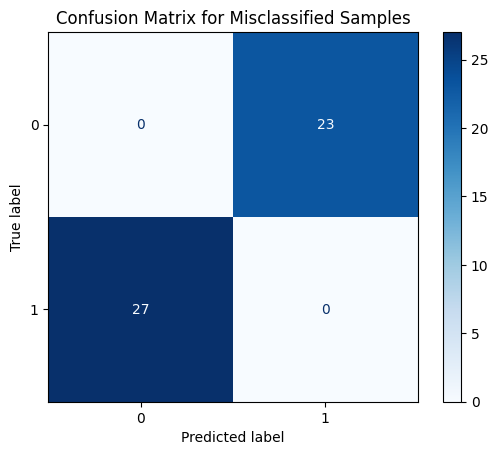

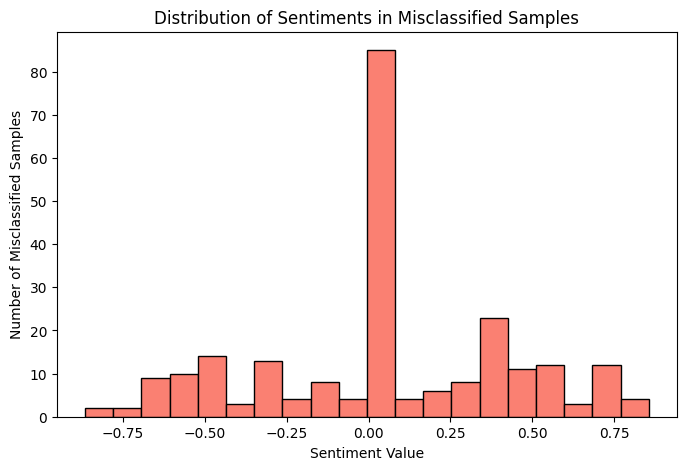

In [144]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert lists to tensors or numpy arrays
y_true = torch.tensor(true_labels).numpy()
y_pred = torch.tensor(pred_labels).numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Misclassified Samples")
plt.show()

import matplotlib.pyplot as plt
from collections import Counter


# Extract sentiment values from misclassified samples
misclassified_sentiments = [sample['sent'].item() for sample in misclassified]

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(misclassified_sentiments, bins=20, color='salmon', edgecolor='black')
plt.xlabel('Sentiment Value')
plt.ylabel('Number of Misclassified Samples')
plt.title('Distribution of Sentiments in Misclassified Samples')
plt.show()


tensor([[ 6621,   254,   313, 11718,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  434,    19, 13195,   522, 20065,  7113,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [    1,   215,     1,  1415,   514,   756,     4,     1,     1,    17,
             1,  2944,     0,     0,     0,     0,     0],
        [  895,   215,    25,  2066,  2406,  4621,  6477,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  600,  2396,  1196,   377,    58,    67,     4,  3530,   837, 22134,
             0,     0,     0,     0,     0,     0,     0],
        [  128,    25,  1647,   393,    74,    31,   756,   334,  5119,    15,
            45,    66,    17,    45,  1164,     0,     0],
        [ 2385,    98,    90,  6403,  1168,  1101,   924,    62,    15, 11066,
          1106,   765,     0,     0,     0,     0,     0],
        [ 5065,   119,   678,   71